# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import re
import os
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1 Profile data
- Removed clients with missing pay information and client profiles where the sexual orientation quality is absent 

- Changed the name of the 'id' segment to 'customerid' 

- Transformed the 'became_member_on' segment to a datetime article and sexual orientation section from a character to a number. 

- One hot encode a client's participation start year, start Month and age extend


In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
def clean_profile(data_dir = "./data"):
    profile = pd.read_json('data/profile.json',
                           orient='records',
                           lines=True)
    profile_remove = profile[profile.age == 118]

    # Remove customers with N/A income data
    profile = profile[profile['income'].notnull()]

    # Remove customers with unspecified gender
    profile = profile[profile['gender'] != 'O']
    profile = profile.reset_index(drop=True)

    # Change the name of the 'id' column to 'customerid'
    profile.columns = update_column_name(profile,
                                         'id',
                                         'customerid')

    column_ordering = ['customerid',
                       'gender',
                       'income']

    # Transform the 'became_member_on' column to a datetime object
    profile['became_member_on']= profile['became_member_on'].apply(convert_to_datetime)

    # One hot encode a customer's membership start year
    profile['membershipstartyear'] =\
        profile['became_member_on'].apply(lambda elem: elem.year)
    
    # One hot encode a customer's membership start month
    profile['membershipstartMonth'] =\
        profile['became_member_on'].apply(lambda elem: elem.month)

    # Transform a customer's gender from a character to a number
    recode = {'M': 0, 'F': 1}
    profile.replace({'gender': recode}, inplace=True)
    
    min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
    max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

    profile['agerange'] =\
        pd.cut(profile['age'],
               (range(min_age_limit,max_age_limit + 10, 10)),
               right=False)
    profile['agerange'] = profile['agerange'].astype('str')

    # Return a DataFrame with "clean" customer profile data
    return profile

In [11]:
profile = clean_profile()

In [12]:
profile.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,membershipstartMonth,agerange
0,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)"
1,75,2017-05-09,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,"[70, 80)"
2,68,2018-04-26,0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,"[60, 70)"
3,65,2018-02-09,0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,"[60, 70)"
4,58,2017-11-11,0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,"[50, 60)"


In [13]:
column_ordering = []
agerange_df = pd.get_dummies(profile['agerange'])
column_ordering.extend(agerange_df.columns.values)
profile = pd.concat([profile,agerange_df], axis=1)
profile.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,75,2017-05-09,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,"[70, 80)",0,0,0,0,0,0,0,1,0,0
2,68,2018-04-26,0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,65,2018-02-09,0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,58,2017-11-11,0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0


## 1.2 Portfolio Data
- Changed the name of the 'id' section to 'offerid' 

- Removed underscores from section names 

- One hot encode the 'offertype' section and 'channels' segments


In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
from datetime import datetime
def update_column_name(dataframe,
                       old_column_name,
                       new_column_name):
    column_names = dataframe.columns.values
    select_data = np.array([elem == old_column_name for elem in column_names])
    column_names[select_data] = new_column_name   
    return column_names
def convert_to_datetime(elem):
    return datetime.strptime(str(elem), '%Y%m%d')

In [6]:
def clean_portfolio(data_dir="./data"):
    portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
    
    # Change the name of the 'id' column to 'offerid'
    columns = update_column_name(portfolio,'id','offerid')
    
    # Remove underscores from column names
    portfolio.columns = [re.sub('_', '', elem) for elem in columns]
    return portfolio
portfolio = clean_portfolio()
portfolio

,channels,difficulty,duration,offerid,offertype,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [7]:
column_ordering = ['offerid',
                   'difficulty',
                   'durationdays',
                   'reward']

    # One hot encode the 'offertype' column
offertype_df = pd.get_dummies(portfolio['offertype'])

column_ordering.extend(offertype_df.columns.values)

    # One hot encode the 'channels' columns
ml_binarizerobj = MultiLabelBinarizer()
ml_binarizerobj.fit(portfolio['channels'])

channels_df =\
    pd.DataFrame(ml_binarizerobj.transform(portfolio['channels']),
    columns=ml_binarizerobj.classes_)

column_ordering.extend(channels_df.columns.values)

    # Replace the 'offertype' and 'channels' columns
portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

portfolio = portfolio.drop(columns=['offertype', 'channels'])

In [8]:
portfolio.head()

,difficulty,duration,offerid,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


# 1.3 Transcript Data

- I changed the name of the 'individual' segment to 'customerid'and 'time' section to 'timedays',removed client id's that are not in the client profile DataFrame. also,converted time variable from hours to days 

- Create a two DataFrame that portrays: offers and client exchange occasions. 

- One hot encode offer occasions



In [14]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
def clean_transcript(profile,
                     data_dir = './data'):
    transcript = pd.read_json(os.path.join(data_dir,
                                           'transcript.json'),
                              orient='records',
                              lines=True)

    # Change the name of the 'person' column to 'customerid'
    transcript.columns = update_column_name(transcript,
                                            'person',
                                            'customerid')

    # Remove customer id's that are not in the customer profile DataFrame
    select_data = transcript['customerid'].isin(profile['customerid'])
    transcript = transcript[select_data]

    percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
    print("Percentage of transactions removed: %.2f %%" % percent_removed)

    # Convert from hours to days
    transcript['time'] /= 24.0
    
    # Change the name of the 'time' column to 'timedays'
    transcript.columns = update_column_name(transcript,
                                            'time',
                                            'timedays')

    # Select customer offers
    pattern_obj = re.compile('^offer (?:received|viewed|completed)')

    h_is_offer = lambda elem: pattern_obj.match(elem) != None

    is_offer = transcript['event'].apply(h_is_offer)

    offer_data = transcript[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_order = ['offerid', 'customerid', 'timedays']

    # Create an offerid column
    offer_data['offerid'] =\
        offer_data['value'].apply(lambda elem: list(elem.values())[0])

    # Transform a column that describes a customer offer event
    pattern_obj = re.compile('^offer ([a-z]+$)')

    h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]

    offer_data['event'] = offer_data['event'].apply(h_transform)

    # One hot encode customer offer events
    event_df = pd.get_dummies(offer_data['event'])
    column_order.extend(event_df.columns.values)

    # Create a DataFrame that describes customer offer events
    offer_data = pd.concat([offer_data, event_df], axis=1)
    offer_data.drop(columns=['event', 'value'])
    offer_data = offer_data[column_order]

    # Select customer transaction events
    transaction = transcript[is_offer == False]
    transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
    transaction['amount'] =\
        transaction['value'].apply(lambda elem: list(elem.values())[0])

    # Create a DataFrame that describes customer transactions
    transaction = transaction.drop(columns=['event','timedays'])
    column_order = ['customerid', 'amount']
    transaction = transaction[column_order]

    return offer_data, transaction

In [16]:
transcript.shape

(306534, 4)

In [17]:
offer_data, transaction = clean_transcript(profile)
#transaction = pd.merge(transaction, offer_data, on='customerid')
transaction.head()

Percentage of transactions removed: 12.31 %


,customerid,amount
0,02c083884c7d45b39cc68e1314fec56c,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56
2,54890f68699049c2a04d415abc25e717,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,18.97


In [18]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


# 2. Explore the Data

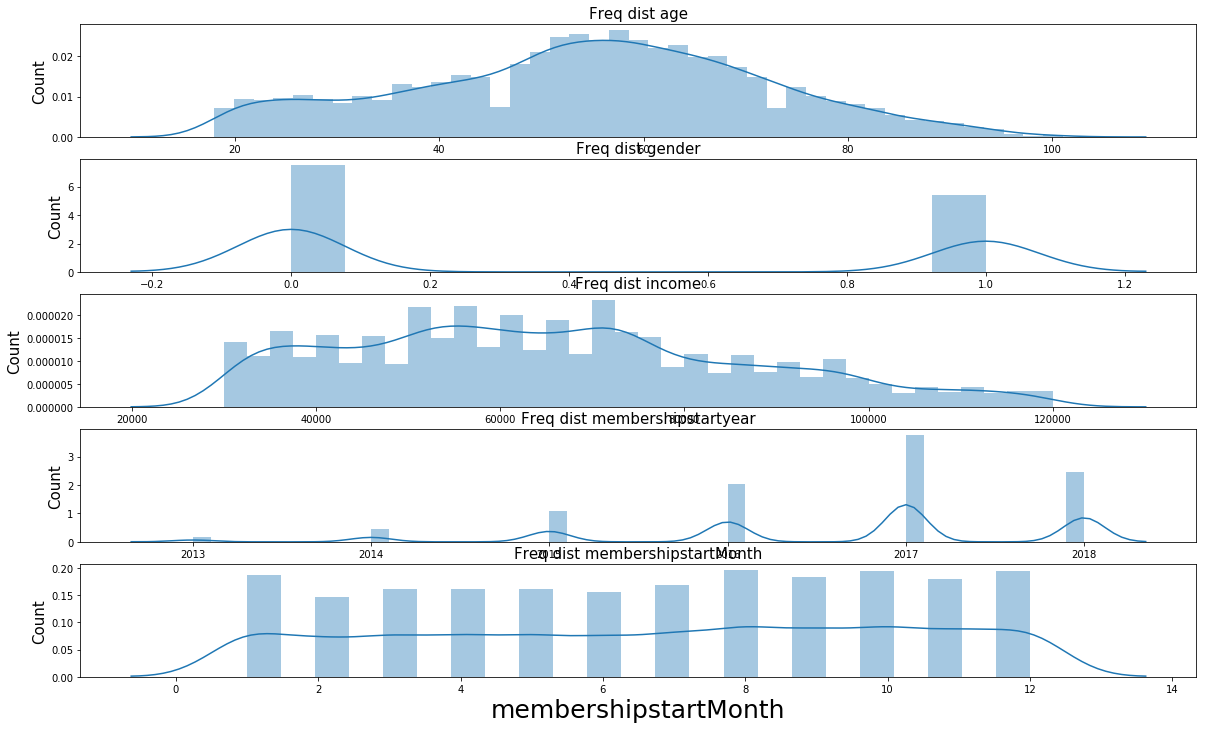

In [19]:
col_names = ['age', 'gender', 'income', 'membershipstartyear','membershipstartMonth']

fig, ax = plt.subplots(len(col_names), figsize=(20,12))

for i, col_val in enumerate(col_names):
    sns.distplot(profile[col_val], hist=True, ax=ax[i]) 
    ax[i].set_title("Freq dist " + col_val, fontsize=15)
    ax[i].set_xlabel(col_val, fontsize=25)
    ax[i].set_ylabel('Count', fontsize=15)
plt.show()

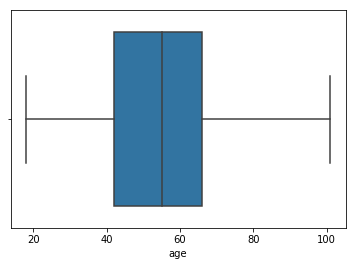

In [21]:
sns.boxplot(x=profile['age'])

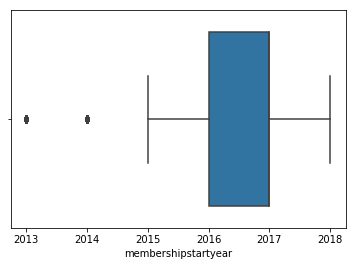

In [22]:
sns.boxplot(x=profile['membershipstartyear'])

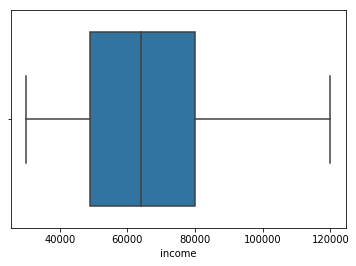

In [20]:
sns.boxplot(x=profile['income'])

### Income by gender for each Year

In [29]:
datamembershipstartyearF = profileforFemale.groupby('membershipstartyear')['income'].sum().reset_index()
datamembershipstartyearF.reset_index(drop=True)
datamembershipstartyearF.head(12)

,membershipstartyear,income
0,2013,4567000.0
1,2014,8468000.0
2,2015,47701000.0
3,2016,112994000.0
4,2017,174463000.0
5,2018,88844000.0


In [30]:
datamembershipstartyearM = profileforMale.groupby('membershipstartyear')['income'].sum().reset_index()
datamembershipstartyearM.reset_index(drop=True)
datamembershipstartyearM.head(12)

,membershipstartyear,income
0,2013,11030000.0
1,2014,29828000.0
2,2015,57476000.0
3,2016,98242000.0
4,2017,187731000.0
5,2018,134868000.0


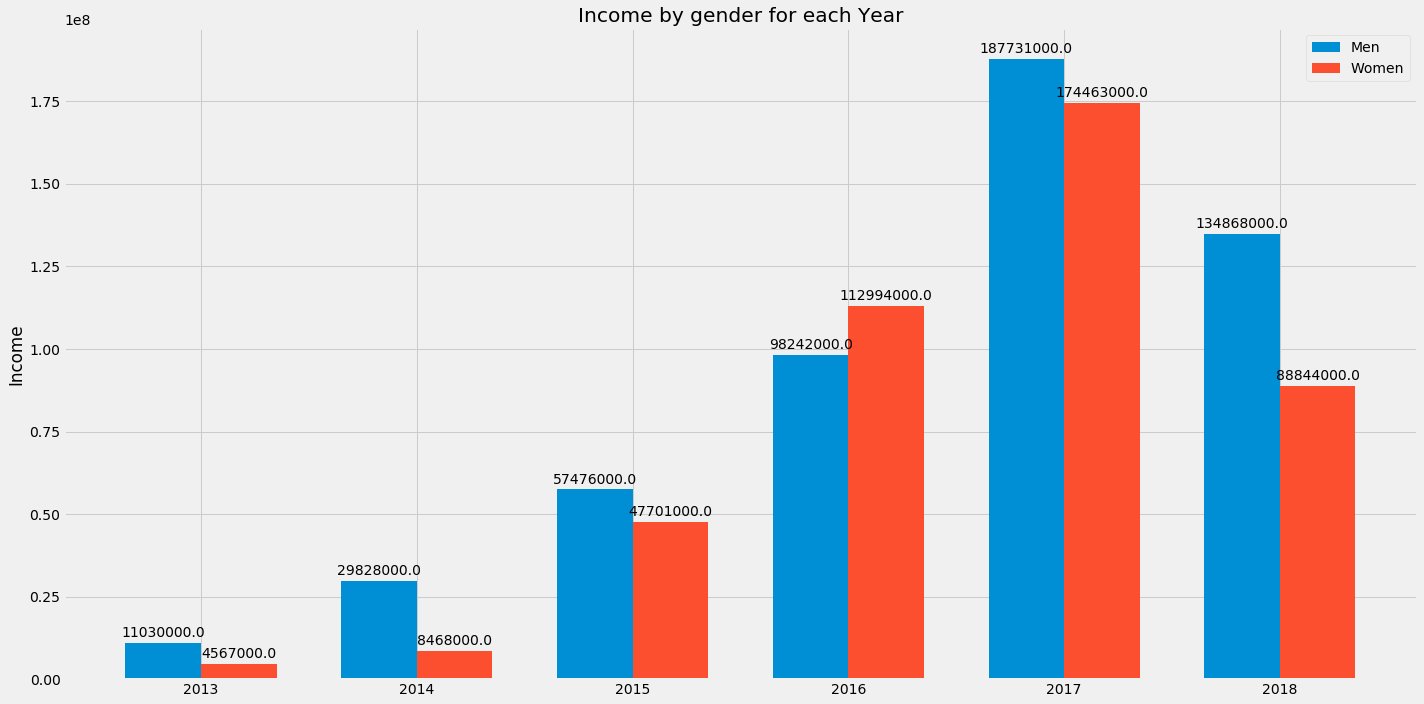

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
labels = datamembershipstartyearM.membershipstartyear
men = datamembershipstartyearM.income
women = datamembershipstartyearF.income

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, men, width, label='Men')
rects2 = ax.bar(x + width/2, women, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Income')
ax.set_title('Income by gender for each Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Income by gender for each Month

In [23]:
profileforFemale = profile.copy()
profileforFemale = profileforFemale[profileforFemale['gender'] == 1]
profileforFemale.head()


,age,became_member_on,gender,customerid,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,75,2017-05-09,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,"[70, 80)",0,0,0,0,0,0,0,1,0,0
5,61,2017-09-11,1,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017,9,"[60, 70)",0,0,0,0,0,0,1,0,0,0
7,62,2016-02-11,1,31dda685af34476cad5bc968bdb01c53,71000.0,2016,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
10,61,2018-05-01,1,a448667f336b42c9a66fc5ffd5d73772,40000.0,2018,5,"[60, 70)",0,0,0,0,0,0,1,0,0,0


In [24]:
datamembershipstartMonthF = profileforFemale.groupby('membershipstartMonth')['income'].sum().reset_index()
datamembershipstartMonthF.reset_index(drop=True)
datamembershipstartMonthF.head(12)

,membershipstartMonth,income
0,1,36809000.0
1,2,27369000.0
2,3,34506000.0
3,4,32908000.0
4,5,32377000.0
5,6,31747000.0
6,7,36168000.0
7,8,41128000.0
8,9,38705000.0
9,10,41857000.0


In [25]:
profileforMale = profile.copy()
profileforMale = profileforMale[profileforMale['gender'] == 0]
profileforMale.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
2,68,2018-04-26,0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,65,2018-02-09,0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,58,2017-11-11,0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0
6,26,2014-02-13,0,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014,2,"[20, 30)",0,0,1,0,0,0,0,0,0,0
8,49,2014-11-13,0,62cf5e10845442329191fc246e7bcea3,52000.0,2014,11,"[40, 50)",0,0,0,0,1,0,0,0,0,0


In [26]:
datamembershipstartMonthM = profileforMale.groupby('membershipstartMonth')['income'].sum().reset_index()
datamembershipstartMonthM.reset_index(drop=True)
datamembershipstartMonthM.head(12)

,membershipstartMonth,income
0,1,47689000.0
1,2,38517000.0
2,3,38677000.0
3,4,40552000.0
4,5,42459000.0
5,6,40005000.0
6,7,40591000.0
7,8,50304000.0
8,9,45555000.0
9,10,47512000.0


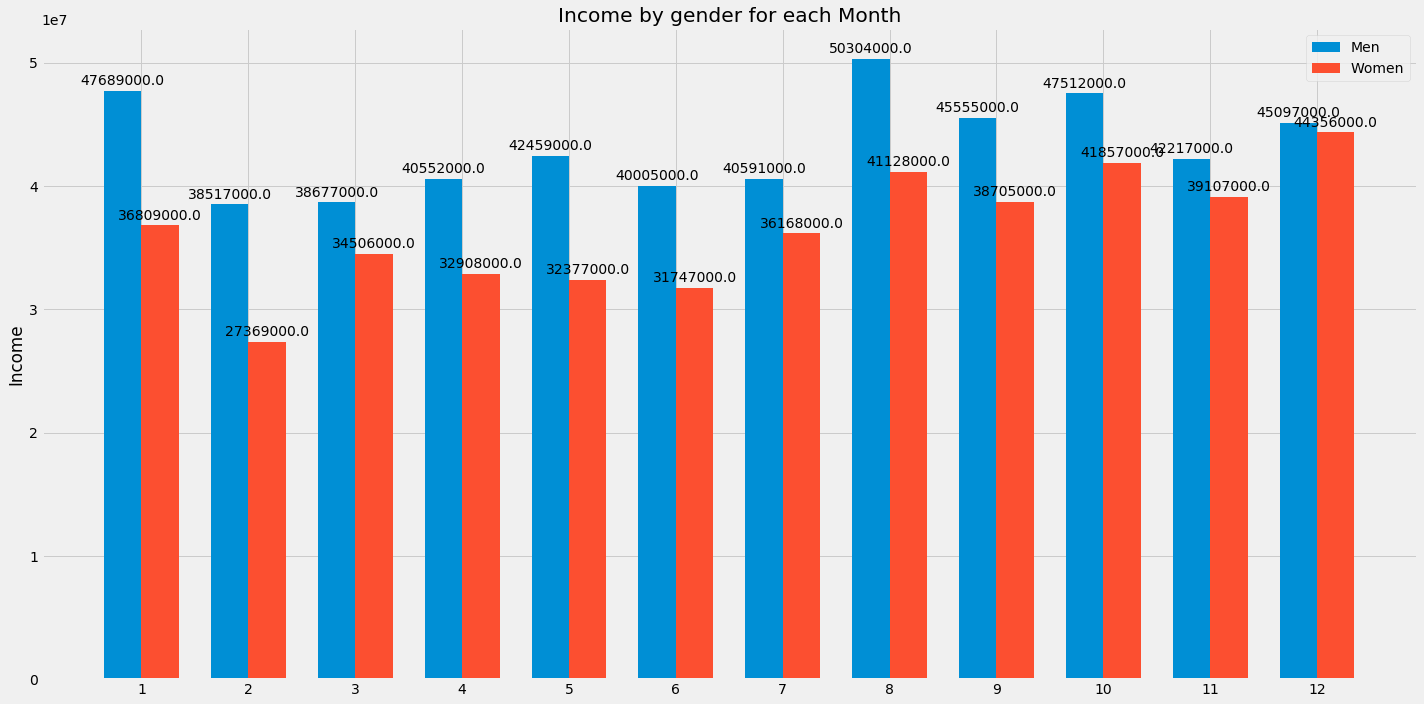

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
labels = datamembershipstartMonthM.membershipstartMonth
men = datamembershipstartMonthM.income
women = datamembershipstartMonthF.income

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, men, width, label='Men')
rects2 = ax.bar(x + width/2, women, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Income')
ax.set_title('Income by gender for each Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Count and Sum Income by Gender 

In [32]:
dataGender = profile.groupby('gender')['income'].sum().reset_index()
dataGender.reset_index(drop=True)
dataGender.head()

,gender,income
0,0,519175000.0
1,1,437037000.0


In [33]:
dataGenderCount = profile.groupby('gender')['income'].count().reset_index()
dataGenderCount.reset_index(drop=True)
dataGenderCount.head()

,gender,income
0,0,8484
1,1,6129


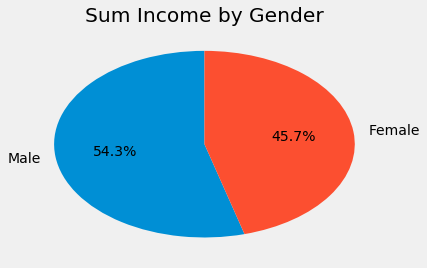

In [34]:

plt.style.use('fivethirtyeight')
slices_hours = dataGender.income
activities = ['Male', 'Female']
plt.pie( slices_hours, startangle=90, labels=activities, autopct='%.1f%%')
plt.title('Sum Income by Gender')
plt.show()

### Timeline for Sum of income by Year

In [35]:
# One hot encode a customer's age range
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

# Make age range 
profile['agerange'] =\
    pd.cut(profile['age'],
            (range(min_age_limit,max_age_limit + 10, 10)),
            right=False)
profile['agerange'] = profile['agerange'].astype('str') 

In [36]:
profile.agerange.value_counts()

[50, 60)      3485
[60, 70)      2952
[40, 50)      2269
[70, 80)      1757
[30, 40)      1503
[20, 30)      1353
[80, 90)       821
[90, 100)      252
[10, 20)       205
[100, 110)      16
Name: agerange, dtype: int64

In [37]:
data_became_member_on = profile.sort_values('became_member_on')
income = data_became_member_on.groupby('became_member_on')['income'].sum().reset_index()
income = income.set_index('became_member_on')
y_income = income['income'].resample('BMS').sum()
income = pd.DataFrame({'became_member_on':y_income.index, 'income':y_income.values})
#store.rename(columns={'Sum_x': 'income', 'Sum_y': 'revenue'}, inplace=True)
income.head()

,became_member_on,income
0,2013-07-01,321000.0
1,2013-08-01,3889000.0
2,2013-09-02,3104000.0
3,2013-10-01,3000000.0
4,2013-11-01,2513000.0


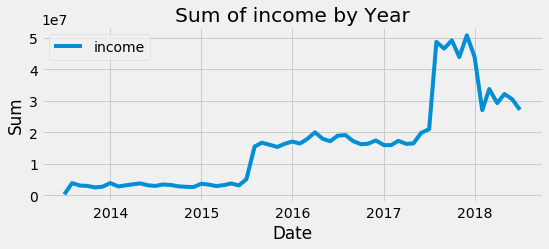

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(income['became_member_on'], income['income'], label = 'income')
#plt.plot(profile['became_member_on'], profile['revenue'], label = 'revenue')
plt.xlabel('Date'); plt.ylabel('Sum'); plt.title('Sum of income by Year')
plt.legend();



### Income for Age Range

In [39]:
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

profile['agerange'] =\
    pd.cut(profile['age'],
            (range(min_age_limit,max_age_limit + 10, 10)),
            right=False)
profile['agerange'] = profile['agerange'].astype('str')
profile.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,75,2017-05-09,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,"[70, 80)",0,0,0,0,0,0,0,1,0,0
2,68,2018-04-26,0,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,65,2018-02-09,0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,58,2017-11-11,0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0


In [40]:
dataAgeRange = profile.groupby('agerange')['income'].sum().reset_index()
dataAgeRange.head()

,agerange,income
0,"[10, 20)",10350000.0
1,"[100, 110)",1187000.0
2,"[20, 30)",69191000.0
3,"[30, 40)",80634000.0
4,"[40, 50)",139711000.0


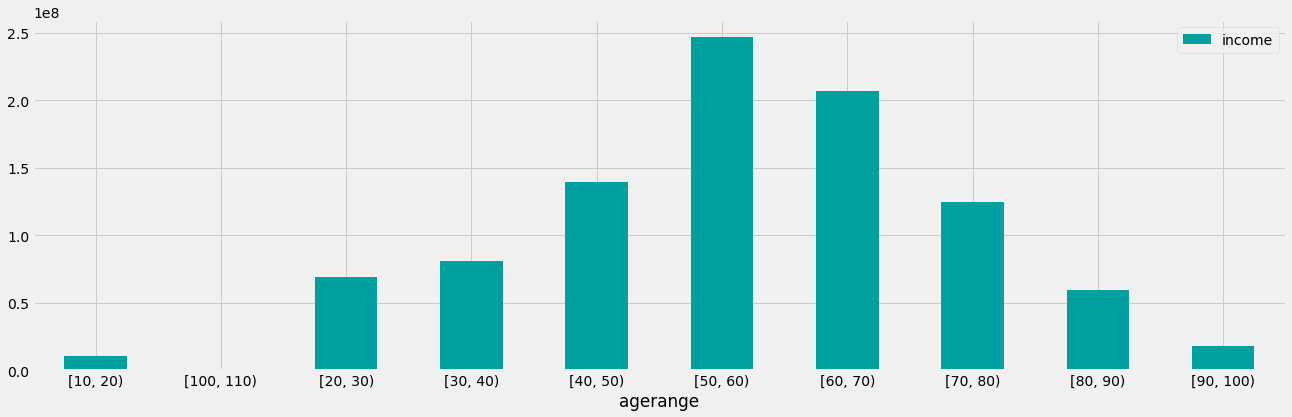

In [41]:
ax = dataAgeRange.plot.bar(x='agerange', y='income', rot=0, figsize=(20,6),color = '#00A0A0')

# 3. Preparing the Data

In [42]:
alldata1 = pd.merge(profile, transaction, on='customerid')
alldata2 = pd.merge(alldata1, offer_data, on='customerid')
alldata3 = pd.merge(alldata2, portfolio, on='offerid')
alldata3.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)",...,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)",0,0,...,5,7,5,1,0,0,1,1,0,1
1,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)",0,0,...,5,7,5,1,0,0,1,1,0,1
2,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)",0,0,...,5,7,5,1,0,0,1,1,0,1
3,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)",0,0,...,5,7,5,1,0,0,1,1,0,1
4,55,2017-07-15,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,"[50, 60)",0,0,...,5,7,5,1,0,0,1,1,0,1


In [43]:
mean = alldata3.income.mean()
print(mean)

62718.7745663


In [44]:
alldata3['income'] = alldata3.income.map(lambda x: 0 if x <= 62718.77  else 1)

In [45]:
n_records = len(alldata3)
n_greater_mean = len(alldata3[alldata3.income == 1])
n_at_most = len(alldata3[alldata3.income == 0])

In [46]:
print(n_records)
print(n_greater_mean)
print(n_at_most)

1308957
608367
700590


# 4.Modeling

In [47]:
alldata3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308957 entries, 0 to 1308956
Data columns (total 34 columns):
age                     1308957 non-null int64
became_member_on        1308957 non-null datetime64[ns]
gender                  1308957 non-null int64
customerid              1308957 non-null object
income                  1308957 non-null int64
membershipstartyear     1308957 non-null int64
membershipstartMonth    1308957 non-null int64
agerange                1308957 non-null object
[10, 20)                1308957 non-null uint8
[100, 110)              1308957 non-null uint8
[20, 30)                1308957 non-null uint8
[30, 40)                1308957 non-null uint8
[40, 50)                1308957 non-null uint8
[50, 60)                1308957 non-null uint8
[60, 70)                1308957 non-null uint8
[70, 80)                1308957 non-null uint8
[80, 90)                1308957 non-null uint8
[90, 100)               1308957 non-null uint8
amount                  130895

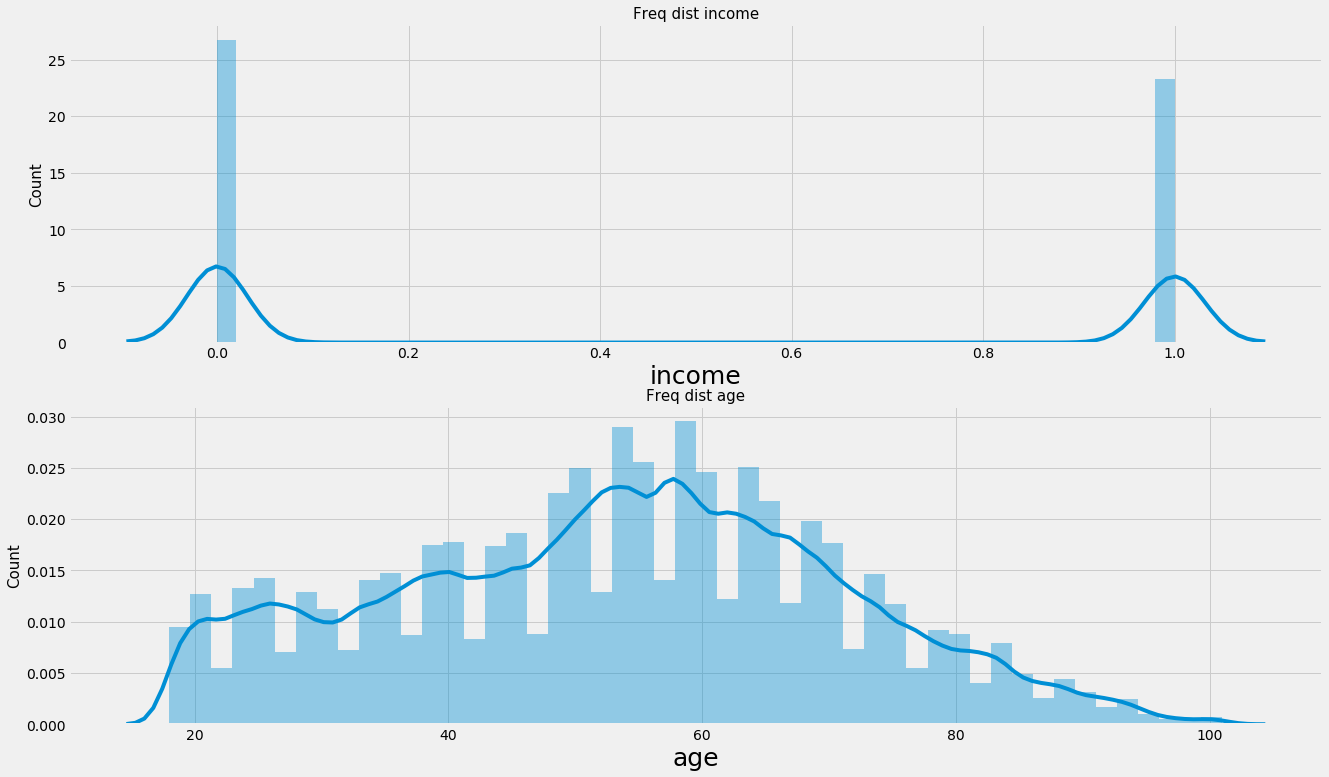

In [48]:
col_names = ['income', 'age']

fig, ax = plt.subplots(len(col_names), figsize=(20,12))

for i, col_val in enumerate(col_names):
    sns.distplot(alldata3[col_val], hist=True, ax=ax[i]) 
    ax[i].set_title("Freq dist " + col_val, fontsize=15)
    ax[i].set_xlabel(col_val, fontsize=25)
    ax[i].set_ylabel('Count', fontsize=15)
plt.show()

## 1.Transforming Skewed Continuous Features

In [49]:
income_raw = alldata3['income']
features_raw = alldata3.drop(['income'], axis = 1)

In [50]:
features_raw = features_raw.drop(['became_member_on','customerid','agerange', 'offerid',
                          '[10, 20)','[100, 110)',
                          '[20, 30)','[30, 40)',
                          '[40, 50)','[50, 60)',
                          '[60, 70)','[70, 80)',
                          '[80, 90)','[90, 100)'], axis = 1)

In [51]:
features_raw.head()

,age,gender,membershipstartyear,membershipstartMonth,amount,timedays,completed,received,viewed,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,55,1,2017,7,21.51,17.0,0,1,0,5,7,5,1,0,0,1,1,0,1
1,55,1,2017,7,21.51,22.0,1,0,0,5,7,5,1,0,0,1,1,0,1
2,55,1,2017,7,32.28,17.0,0,1,0,5,7,5,1,0,0,1,1,0,1
3,55,1,2017,7,32.28,22.0,1,0,0,5,7,5,1,0,0,1,1,0,1
4,55,1,2017,7,23.22,17.0,0,1,0,5,7,5,1,0,0,1,1,0,1


In [52]:
skewed = ['membershipstartyear', 'membershipstartMonth']
features_raw[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

## 2.Normalizing Numerical Features¶

In [53]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'membershipstartyear',
             'membershipstartMonth','amount',
             'timedays','difficulty',
             'duration','reward']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,gender,membershipstartyear,membershipstartMonth,amount,timedays,completed,received,viewed,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,0.445783,1,0.800198,0.74062,0.020203,0.571429,0,1,0,0.25,0.571429,0.5,1,0,0,1,1,0,1


### Shuffle and Split Data¶

In [54]:
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, income_raw, test_size = 0.2, random_state = 0)



/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
# Show the results of the split
print("Training set has")
print((X_train.shape[0])) 
print("Testing set has ")
print((X_test.shape[0])) 

Training set has
1047165
Testing set has 
261792


### Evaluating Model Performance¶

In [56]:
accuracy = n_greater_mean/(float(n_records))
# Calculate F-score using the formula above for beta = 0.5
beta = 0.5
# precision = True +ve / (True_+ve + False_+ve)
precision = n_greater_mean / float(n_greater_mean + n_at_most)
# recall = True +ve / (True_+ve + False_-ve)
recall = n_greater_mean / float(n_greater_mean + 0)

fscore = (1 + np.square(beta))*(precision * recall)/float((np.square(beta)*precision) + recall)

print ("Naive Predictor:")
print(accuracy)
print("F-score:")
print(fscore)

Naive Predictor:
0.4647723340033324
F-score:
0.520488279395


### Creating a Training and Predicting Pipeline

In [57]:
from sklearn.metrics import fbeta_score, accuracy_score
from pprint import pprint
from time import time
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):  
    results = {}
    beta = 0.5
    #Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    #Calculate the training time
    results['train_time'] = end - start
    # Get the predictions on the test set,then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    #Calculate the total prediction time
    results['pred_time'] = end - start
    #Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    #Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    #Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)  
    # Success
    print (learner.__class__.__name__)
    print(" trained on ")
    print(sample_size)
    print(" samples.")
    # Print results
    pprint(results)
    # Return the results
    return results

### Initial Model Evaluation

In [58]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score
def evaluate(results, accuracy, f1):
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

DecisionTreeClassifier
 trained on 
10471
 samples.
{'acc_test': 0.68857337122601148,
 'acc_train': 1.0,
 'f_test': 0.66530289837864942,
 'f_train': 1.0,
 'pred_time': 0.1087956428527832,
 'train_time': 0.0906376838684082}
DecisionTreeClassifier
 trained on 
104716
 samples.
{'acc_test': 0.80425299474391887,
 'acc_train': 1.0,
 'f_test': 0.78989613930636582,
 'f_train': 1.0,
 'pred_time': 0.11832261085510254,
 'train_time': 1.1967427730560303}
DecisionTreeClassifier
 trained on 
1047165
 samples.
{'acc_test': 0.99128697591981418,
 'acc_train': 1.0,
 'f_test': 0.99048996938922973,
 'f_train': 1.0,
 'pred_time': 0.1284654140472412,
 'train_time': 21.115031003952026}
AdaBoostClassifier
 trained on 
10471
 samples.
{'acc_test': 0.77142922625595889,
 'acc_train': 0.73333333333333328,
 'f_test': 0.77607563431889937,
 'f_train': 0.73302469135802473,
 'pred_time': 1.7808022499084473,
 'train_time': 0.48599863052368164}
AdaBoostClassifier
 trained on 
104716
 samples.
{'acc_test': 0.77504660188

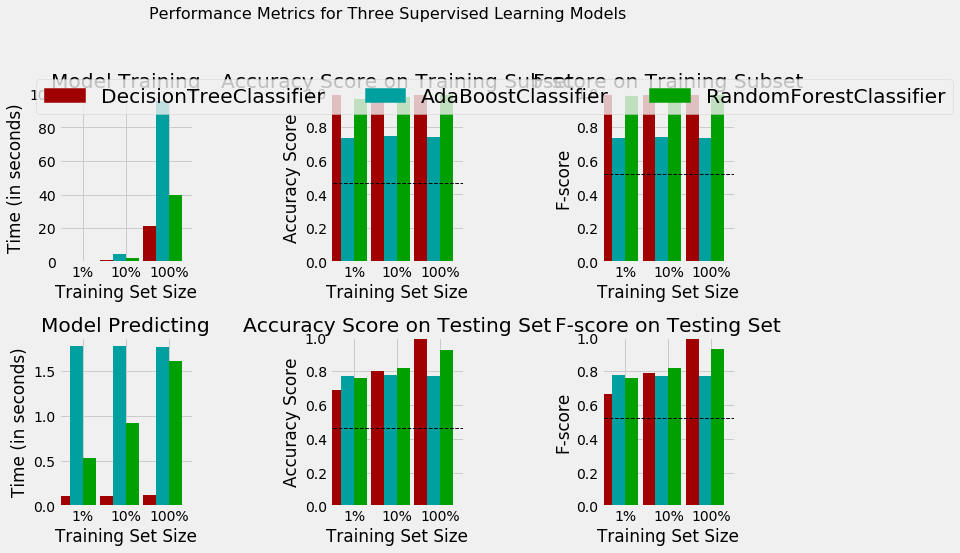

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state = 40)  
clf_B = AdaBoostClassifier (random_state = 40)
clf_C = RandomForestClassifier(random_state = 40)

samples_100 = int(len(X_train))
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

### Support Vector Machines (SVM) 

- true application: Bioinformatics like malignant growth characterization. 

- Strengths: SVMs can be a helpful instrument for bankruptcy examination, on account of non-consistency in the information, for instance when the information are not consistently appropriated or have an obscure dispersion. 

- Weaknesses: is the absence of straightforwardness of results. 

- Model is a decent applicant in light of the fact that our dataset isn't that enormous to be a hindrance. additionally our information is both numerical and all out information and SVM can handel with it. There are profoundly slanted element conveyances, for example, 'capital-addition' and 'capital-misfortune's that are not routinely appropriated and SVM is a decent possibility for this case. 

### Random Forest 

- Computer Vision. 

- qualities: Parallel preparing is conceivable, Work with huge datasets with parcel of properties. 

- shortcomings: Needs an ideal opportunity to prepare since it manufactures various classifiers. 

- Given that we have a huge dataset to such an extent that a solitary Decision Tree will in all probability overfit, Random Forests will perform relatively better as it is a gathering of Trees prepared on tests of the dataset. 

### AdaBoost: 

- genuine application: it is utilized in the regions of video and picture acknowledgment. 

- qualities: it tends to be utilized related to numerous different kinds of learning calculations to improve execution in certain issues it very well may be less powerless to the overfitting issue than other learning calculations. 

- shortcomings: AdaBoost is delicate to boisterous information and anomalies. 

- Model is a decent up-and-comer since it will have the option to take the full dataset. What's more, numerous frail students can make one in number student. Likewise, the preparation information is of a great (there are no invalid or missing passages).

### Improving Results
In this final section, I will choose from the three supervised learning models the best model to use on the student data. I will then perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F-score.

In [60]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(random_state=2)
#Create the parameters list you wish to tune
max_depth=[5,8]
max_depth.append(None)
scorer = make_scorer(fbeta_score, beta = 0.5)
parameters={'max_features': ['auto'],
            'max_depth' : max_depth,
            'n_estimators': [10,50],
            'min_samples_split': [2,10],
            'min_samples_leaf': [1,4],
           }
# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=3, verbose=2)
# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)
# Get the estimator
best_clf = grid_fit.best_estimator_
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
# Report the before-and-afterscores
print ("Unoptimized model\n")
print ("Accuracy score on testing data:", (accuracy_score(y_test, predictions)))
print ("F-score on testing data: ",format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n")
print ("Final accuracy score on the testing data: ",(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data:",(fbeta_score(y_test, best_predictions, beta = 0.5)))
# Report scores on training dataset
train_predictions = best_clf.predict(X_train)
print ("\nTraining Data\n")
print ("Final accuracy score on the training data: ",(accuracy_score(y_train, train_predictions)))
print ("Final F-score on the training data: ",(fbeta_score(y_train, train_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 -  10.9s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 -  10.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 -  10.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 -  53.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 -  52.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 -  52.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 57.5min finished


Unoptimized model

Accuracy score on testing data: 0.928714399218
F-score on testing data:  0.9305657443987535

Optimized Model

Final accuracy score on the testing data:  0.943577343845
Final F-score on the testing data: 0.93914596824

Training Data

Final accuracy score on the training data:  0.999909278862
Final F-score on the training data:  0.999909169036


#### Final Model Evaluation
- The enhanced model has a precision of 86.06% on the test set and a F-score of 0.7316. 

- These scores are possibly better than those of unoptimized model. 

- But, when contrasted with the gullible indicator, the streamlined model performs truly well. The credulous indicator has precision of < 46%. The F-score also is greatly improved, for the enhanced model.

## Feature Importance

### Extracting Feature Importance

#### In this code:
- Import an administered taking in model from sklearn in the event that it is unique in relation to the three utilized before. 

- Train the administered model on the whole preparing set. 

- Extract the element significances utilizing '.feature_importances_'.

In [61]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  

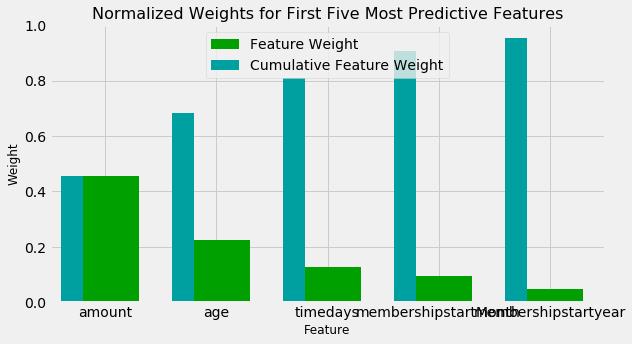

In [62]:
from sklearn.ensemble import RandomForestClassifier

# TODO: Train the supervised model on the training set 
model = RandomForestClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

As per me, age was the most significant element. Be that as it may, as a general rule, sum is a higher priority than age.

### Feature Selection

In [63]:
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print ("Final Model trained on full data\n------")
print ("Accuracy on testing data: {:.4f}",(accuracy_score(y_test, best_predictions)))
print ("F-score on testing data: {:.4f}",(fbeta_score(y_test, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on testing data: {:.4f}",(accuracy_score(y_test, reduced_predictions)))
print( "F-score on testing data: {:.4f}",(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: {:.4f} 0.943577343845
F-score on testing data: {:.4f} 0.93914596824

Final Model trained on reduced data
------
Accuracy on testing data: {:.4f} 0.985175253636
F-score on testing data: {:.4f} 0.986222762852


## Results 
My examination recommends that the subsequent irregular timberland model has a preparation information precision of 0.944 and a F-score of 0.939. The test informational collection exactness of 0.929 and F-score of 0.931 recommends that the arbitrary woods model I developed didn't overfit the preparation information.

# Conclusion
- The issue that I decided to comprehend was to construct a model that predicts the amount somebody will spend dependent on socioeconomics and offer sort. My technique for taking care of this issue has for the most part two stages. 

- First, I joined offer portfolio, client profile, and exchange information. 

- Second, I surveyed the precision and F-score of a credulous model that accept all offers were effective. 

- Third, I looked at the exhibition of three regulated learning models. This investigation recommends that an irregular timberland model has the best preparing information precision, F-score and Training time. The examination proposes that the last model prepared on decreased information (arbitrary woodland model) has exactness of 0.985 and a F-score of 0.986.